In [179]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
import pydot
import datetime

In [180]:
#Importing the Data
digit_data = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

In [181]:
digit_data.values

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [7, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [9, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [182]:
X_train = digit_data.drop('label', axis=1) /255.0
y_train = digit_data['label']

In [183]:
X_train.shape

(42000, 784)

In [184]:
class_names = [0,1,2,3,4,5,6,7,8,9]

In [185]:
class_names[y_train[10]]

8

In [220]:
model = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(300,activation='relu'),
    Dense(100,activation='relu'),
    Dense(100,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model1 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(500,activation='relu'),
    Dense(1000,activation='relu'),
    Dense(300,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model2 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(500,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model3 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(300,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model4 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(1000,activation='relu'),
    Dense(100,activation='relu'),
    Dense(100,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])

models = [model,model1,model2,model3,model4]

In [187]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_39 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_40 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_41 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_42 (Dense)             (None, 10)                1010      
Total params: 286,810
Trainable params: 286,810
Non-trainable params: 0
_______________________________________________

In [188]:
model.layers

In [189]:
model.layers[1].name

'dense_38'

In [190]:
weights, biases = model.layers[1].get_weights()

In [191]:
weights

array([[ 0.04351459,  0.06729858,  0.05860534, ...,  0.06473926,
         0.03480405, -0.04667748],
       [ 0.05644149,  0.01717831, -0.05331584, ...,  0.00453606,
        -0.04309763,  0.04175266],
       [ 0.06628537, -0.00541593,  0.06766963, ..., -0.02068083,
         0.02521397, -0.05489121],
       ...,
       [-0.01421616,  0.03710148,  0.05968791, ...,  0.01428995,
         0.03941083,  0.03174939],
       [-0.0142361 ,  0.04387172,  0.02772877, ..., -0.00281312,
         0.01865653,  0.07279627],
       [ 0.03784442,  0.01641532, -0.06965311, ...,  0.06716779,
        -0.03718388, -0.00776191]], dtype=float32)

In [192]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [193]:
weights.shape

(784, 300)

In [194]:
biases.shape

(300,)

In [221]:
for m in models:
    m.compile(loss='sparse_categorical_crossentropy',
        optimizer='sgd',
        metrics=['accuracy'])

In [206]:
for m in models:
    m.fit(X_train,y_train,
        epochs=40,
        validation_split=0.2)

accuracy: 0.9714
Epoch 23/40
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0115 - accuracy: 0.9984 - val_loss: 0.0905 - val_accuracy: 0.9744
Epoch 24/40
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0102 - accuracy: 0.9989 - val_loss: 0.0953 - val_accuracy: 0.9732
Epoch 25/40
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0086 - accuracy: 0.9992 - val_loss: 0.0929 - val_accuracy: 0.9733
Epoch 26/40
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0078 - accuracy: 0.9993 - val_loss: 0.0935 - val_accuracy: 0.9730
Epoch 27/40
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0067 - accuracy: 0.9995 - val_loss: 0.0934 - val_accuracy: 0.9738
Epoch 28/40
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0058 - accuracy: 0.9997 - val_loss: 0.0936 - val_accuracy: 0.9756
Epoch 29/40
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0051 - accuracy: 0.9998 - val_loss

In [210]:
models[0].history

<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000018472049F10> Graph


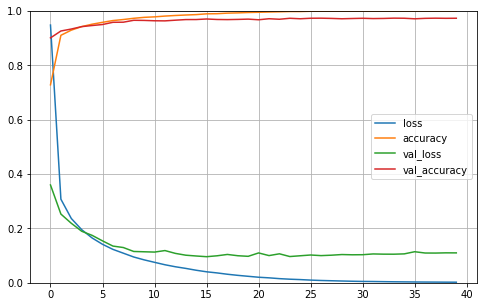

<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000018470233BB0> Graph


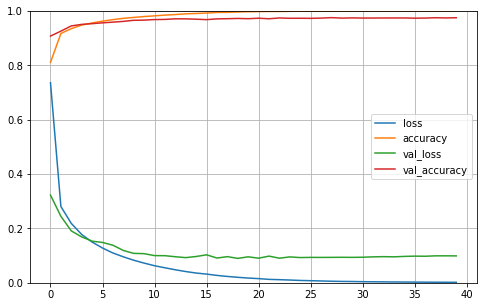

<tensorflow.python.keras.engine.sequential.Sequential object at 0x000001847205C070> Graph


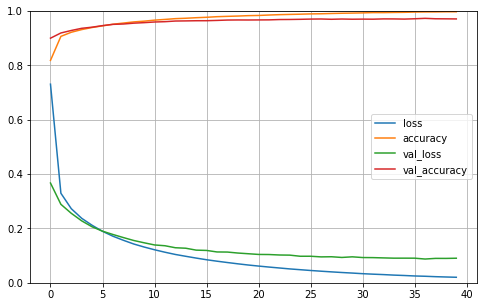

<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000018472035DC0> Graph


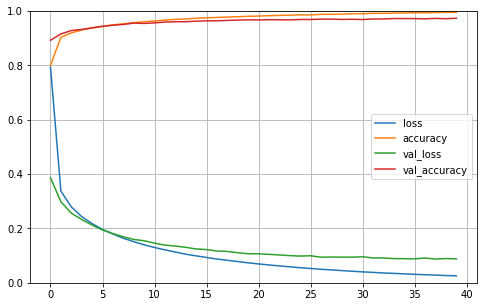

<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000184720BEA30> Graph


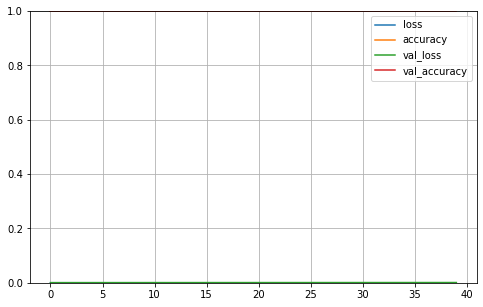

In [214]:
for m in models:
    print(f'{m} Graph')
    pd.DataFrame(m.history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

In [222]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=True)
history = models[4].fit(X_train,y_train, epochs=40, 
    validation_split=0.2, callbacks=[checkpoint_cb])
best_model = keras.models.load_model('my_keras_model.h5')

Epoch 1/40
1050/1050 [==============================] - 4s 4ms/step - loss: 0.7833 - accuracy: 0.8016 - val_loss: 0.3162 - val_accuracy: 0.9082
Epoch 2/40
1050/1050 [==============================] - 4s 4ms/step - loss: 0.2783 - accuracy: 0.9187 - val_loss: 0.2309 - val_accuracy: 0.9336
Epoch 3/40
1050/1050 [==============================] - 4s 4ms/step - loss: 0.2125 - accuracy: 0.9379 - val_loss: 0.1897 - val_accuracy: 0.9457
Epoch 4/40
1050/1050 [==============================] - 4s 3ms/step - loss: 0.1726 - accuracy: 0.9509 - val_loss: 0.1694 - val_accuracy: 0.9499
Epoch 5/40
1050/1050 [==============================] - 4s 4ms/step - loss: 0.1417 - accuracy: 0.9594 - val_loss: 0.1472 - val_accuracy: 0.9564
Epoch 6/40
1050/1050 [==============================] - 4s 4ms/step - loss: 0.1208 - accuracy: 0.9645 - val_loss: 0.1451 - val_accuracy: 0.9558
Epoch 7/40
1050/1050 [==============================] - 4s 4ms/step - loss: 0.1019 - accuracy: 0.9707 - val_loss: 0.1243 - val_accuracy:

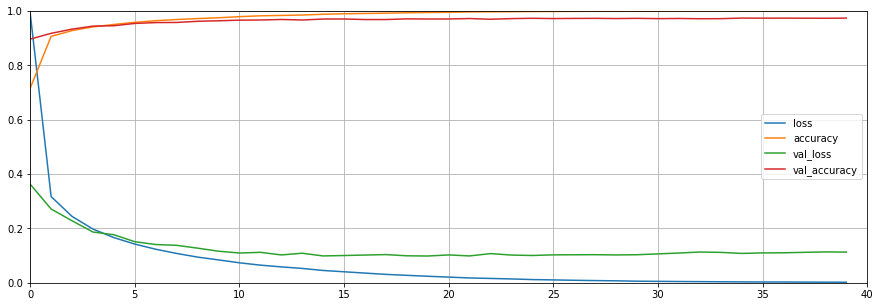

In [228]:
import matplotlib.pyplot as plt

pd.DataFrame(digits.history).plot(figsize=(15,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.gca().set_xlim(0,40)

plt.show()

In [ ]:
digits = model.fit(X_train, y_train,
    epochs=40,
    validation_split=0.2)
    
pd.DataFrame(digits.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [233]:
test_predictions = best_model.predict(test_data)

In [234]:
test_predictions

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [235]:
test_predictions_classes = np.argmax(best_model.predict(test_data), axis=-1)

In [236]:
results = pd.DataFrame(test_predictions_classes)
results.index = np.arange(1, len(results) + 1)
results.to_csv('results.csv')